# Introduction

In this notebook, we are going to practice building a 2D Convolutional Neural Network to process the MNIST dataset. This is a classic problem, the goal is to build a tool which can accurately classify images of hand written digits as 0, 1, 2, etc. Some common applications for this kind of program include reading text off bank checks, reading hand written zip codes for the post office.


# Imports

We start by importing the packages and modules we will be needing for this project.

In [ ]:
# Load standard numerical and plotting packages
import numpy as np
import matplotlib.pyplot as plt

# Load some machine learning packages
from sklearn.model_selection import train_test_split

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Import our neural network building tools
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

In [ ]:
# Set plotting preferences
import matplotlib
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

## Download the Dataset

The MNIST dataset contains thousands of grayscale images of handwritten digits.

In [ ]:
# Load the MNIST dataset: http://yann.lecun.com/exdb/mnist/
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


## Visualize Some Example Images
Let's see how the images look. This function shows a random example along with it's corresponding label.

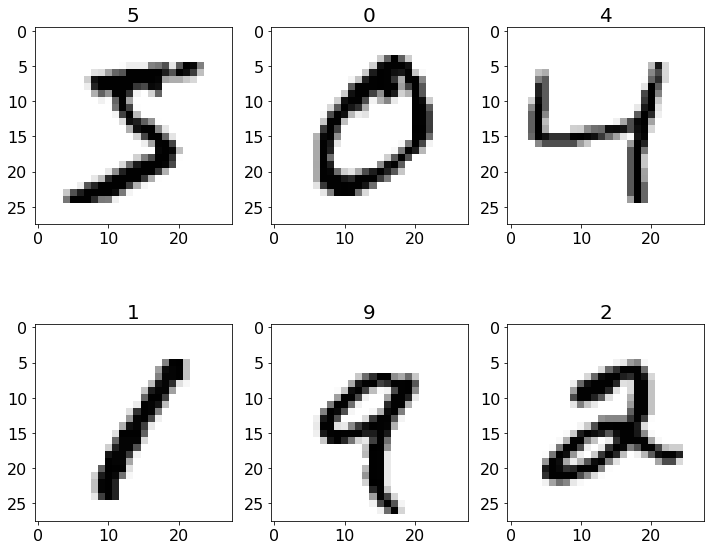

In [ ]:
# Setup the number of images to examine
n_rows = 2
n_cols = 3
img_inds = np.random.randint(0, len(y_train), size=n_rows*n_cols)
# Initialize a set of subplots to populate and an image counter
fig, ax_arr = plt.subplots(n_rows, n_cols, figsize=(12, 10))
i_img = 0
img_ind =0

# Loop over the axes rows and columns
for ax_row in range(n_rows):
    for ax_col in range(n_cols):
        # Grab the axes instance for this row/column
        this_ax = ax_arr[ax_row, ax_col]

        # Show the image and update the title with the label
        this_ax.imshow(X_train[img_ind], cmap='gray_r')
        this_ax.set_title(y_train[img_ind], fontdict={'size': 20})

        # Increment the image index
        img_ind += 1

## Normalize the Image Data

As was explained in the tutorial notebook, it is very helpful to normalize the input data so that it falls in the range $\left[0, 1\right]$.

In [ ]:
# Use your brain and think about what steps are necessary to normalize the data
X_train = X_train.astype(np.float32)/255.0 # <-- Apply normalization on this line
X_test = X_test.astype(np.float32)/255.0 # <-- Apply normalization on this line

# Appy one-hot encoding to the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Include an Axis for Color Channels

Recall from the tutorial notebook that it is necessary to make sure that there is a "channel" axis in our training and test data to match what is expected by TensorFlow.

In [ ]:
# Use your mighty brain again! Add a fourth axis to the image data if necessary
X_train = X_train[:, : , :, np.newaxis] # <-- Reshape the data on this line (see Tutorial for an example)
X_test = X_test[:, : , :, np.newaxis] # <-- Reshape the data on this line (see Tutorial for an example)

## Build a CNN Model
In this section, you are going to write our yown 2D-CNN! Luckily for us, keras has a nice 'Conv2D' layer we can use to make this a bit easier.

To practice building a *specific* CNN architecture, your task is to build the same architecture shown in this diagram.

![CNN Architecture](https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/CNN-example-block-diagram.jpg)

In [ ]:
def initialize_model():
    """Constructs a TensorFlow CNN model"""
    # Clear out any old versions of the models
    tf.keras.backend.clear_session()

    # Initialize a `Sequential` model so we can just add layers sequentially
    model = tf.keras.Sequential()
    
    # Insert an `Input` layer so that you can just focus on which convolutional
    # and activation layers to add.
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))

    # Add the contents of `Layer 1` from the diagram above
    ### YOUR CODE HERE ###
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5,
                                 padding='valid',
                                 activation=tf.nn.relu))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=2, 
                                       padding='valid',
                                       data_format='channels_last'))

    # Add the contents of `Layer 2` from the diagram above
    ### YOUR CODE HERE ###
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5,
                                 padding='valid',
                                 activation=tf.nn.relu))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=2, 
                                       padding='valid',
                                       data_format='channels_last'))

    # Add a `Flatten` layer to convert from feature maps into feature vectors
    ### YOUR CODE HERE ###
    model.add(tf.keras.layers.Flatten())
    # Apply classification fully connected (`Dense`) layers
    model.add(tf.keras.layers.Dense(3164, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))

    # NOTE: first dense layer uses `relu` and second uses `softmax`
    ### YOUR CODE HERE ###
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
    return model

Now we can execute the model initialization code and summarize the model structure.

In [ ]:
# Run the initialization model and print the contents to the user
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3164)              3

## Compile and Train the Model

Specify the loss function and optimization routine. Then compile the model you designed. Compiltation of the Keras model initializes the model weights and sets some other model properties.

In [ ]:
# Specify the loss function to use
loss_func = tf.keras.losses.categorical_crossentropy

# Use the "Adam" adaptive learning algorithm to optimize the filter weights
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Generate a list of metrics to print
metrics_to_print = ['accuracy']

# Compile the model using the specified loss function and potimizer
model.compile(loss=loss_func, optimizer=opt, metrics=metrics_to_print)

With your model compiled, run the training routine.

In [ ]:
#This function is called after each epoch
#(It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

history = model.fit(X_train,        # Train examples
          y_train,                  # Train labels
          epochs=3,                 # number of epochs
          batch_size= 256,          # number of images for each iteration
          callbacks=[garbage_collect_callback()],
          validation_data=(X_test, y_test), # Data for validation
          verbose=True)             # Print info about optimization process

Epoch 1/3
235/235 [==============================] - 78s 331ms/step - loss: 0.5914 - accuracy: 0.8549 - val_loss: 0.1916 - val_accuracy: 0.9440
Epoch 2/3
235/235 [==============================] - 77s 327ms/step - loss: 0.1525 - accuracy: 0.9554 - val_loss: 0.1080 - val_accuracy: 0.9676
Epoch 3/3
235/235 [==============================] - 78s 331ms/step - loss: 0.0968 - accuracy: 0.9717 - val_loss: 0.0692 - val_accuracy: 0.9797


## Evaluate Model Performance

Now that the model has been trained, we can use it to generate predictions and evaluate its performance.

In [ ]:
# Evaluate model using the test images
test_pred = model.predict(X_test)
scores = model.evaluate(X_test, y_test, verbose=False)
print('Testing model on test set:')
print(f'Model Loss: {scores[0]:.3f}, {metrics_to_print[0]}: {scores[1]:.3f}')

313/313 [==============================] - 4s 14ms/step
Testing model on test set:
Model Loss: 0.069, accuracy: 0.980


Let's take a look at the confusion matrix for these model predictions

In [ ]:
# First, convert the one-hot encoded true labels and predictied labels back into
# a numerical classification value. This can be accomplished with the `argmax`
# function and that neat `axis` keyword, again.
test_true_labels = y_test.argmax(axis=1)
test_pred_labels = test_pred.argmax(axis=1)

# Generate the confusion matrix using these labels
mat = confusion_matrix(test_true_labels, test_pred_labels)
print(mat)

[[ 972    0    1    0    0    1    1    1    4    0]
 [   0 1123    5    1    0    0    1    0    5    0]
 [   4    1 1015    3    1    0    0    4    4    0]
 [   1    0    3  992    0    3    0    3    5    3]
 [   1    0    3    0  968    0    1    1    3    5]
 [   3    0    2   11    0  866    3    1    4    2]
 [   9    3    0    1    3    3  934    0    5    0]
 [   1    4   16    3    0    0    0  994    2    8]
 [   6    0    3    2    2    0    1    3  953    4]
 [   5    4    0    5    8    1    0    5    1  980]]


To get a more visual representation of the matrix, let's plot it in matplotlib.

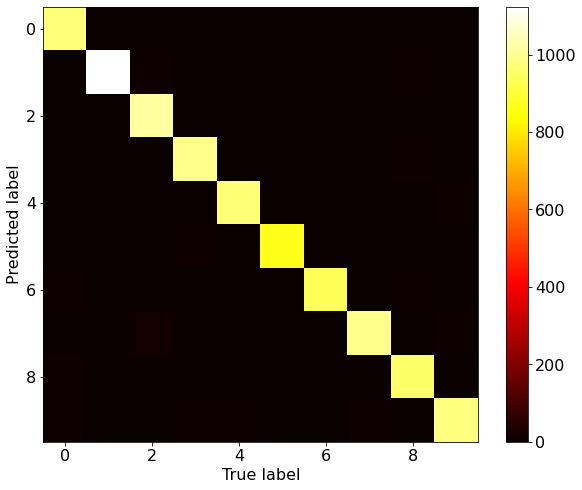

In [ ]:
# Generate a new figure
plt.figure(figsize=(10,8))

# Display the confusion matrix
plt.imshow(mat, cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

Wow! If you successfully built and trained that model, it looks like it does pretty well!

# Visualizing Your Model

Now that your model has been fully trained, let's see what its kernels and features look like.

## Visualizing Kernels

In this section, we are going to visually examine some of the kernels which were learned during the training process. These are effectively the "feature extractors" that proved to be so effective. Perhaps by examining them, we can gain some insight into what particular features are useful for classifying hand drawn digits.

In [ ]:
def get_kernels(model, layer_number):
    """Grab the kernels from the specified layer"""
    # Grab the kernels and biases for the specified layer
    conv_layers = [l for l in model.layers
                   if isinstance(l, tf.keras.layers.Conv2D)]
    layer = conv_layers[layer_number]
    kernels, bias = layer.get_weights()

    return kernels

def get_grid_size(kernels):
    """Computes the necessary grid-size to show all the kernels or outputs"""
    # Count the number of kernels and plan a plotting strategy
    num_kernels = kernels.shape[-1]
    grid_size = np.int(np.ceil(np.sqrt(num_kernels)))

    return grid_size

# Build a function to help visualize the contents of our model
def visualize_kernels(model, layer_number):
    """Displays some of the kernels from the specified layer number"""
    # Grab the kernels for the specified layer
    kernels = get_kernels(model, layer_number)

    # Count the number of kernels and compute the necessary plot grid size
    num_kernels = kernels.shape[-1]
    grid_size = np.int(np.ceil(np.sqrt(num_kernels)))

    # Initialize a figure for plotting
    fig = plt.figure(figsize=(10, 10))

    # Loop over each of the kernels
    for i_kern in range(num_kernels):
        # Create a subplot to display this kernel
        ax = plt.subplot(grid_size, grid_size, i_kern+1)

        # Display the kernel for the user to view
        ax.imshow(kernels[:,:,0,i_kern], cmap='gray_r')
        
        # Remove those distracting tick labels
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

In the next cell, we use the defined visualization functions to examine the kernels of the trained model.

<ipython-input-27-a6a5fcc89274>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_size = np.int(np.ceil(np.sqrt(num_kernels)))


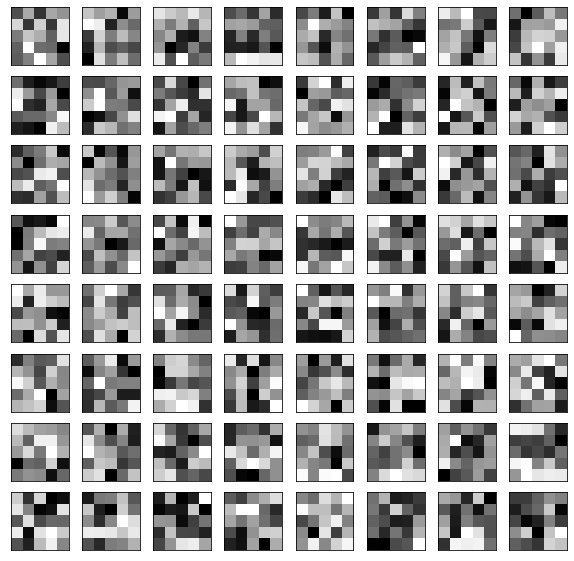

In [ ]:
# Pick a layer of kernels to visualize and then display them
layer_to_visualize = 1
visualize_kernels(model, layer_to_visualize)

**Question 1:** Do these filters look like they're picking up on any particular information? Perhaps there are nice lines and curves in the filters indicating what type of information is being identified as useful features... perhaps there are not.

The filters look random at first, but when we visualized the effects of each filter on an image, the filters focus on the edges and curves of each number. For example for the 7 example below, alot of the filters picked up the corner where the top line connected to the right side of the number.

## Visualizing Features

Now that we have examined the learned kernels, perhaps we can glean some more information by looking at the convolution of an input image with some of these kernels.

In [ ]:
def visualize_convolutions(model, layer_number, input_image):
    # Re-build our trained model in a way that we can grab the convolved outputs
    output = output = [l.output for l in model.layers
        if isinstance(l, tf.keras.layers.Conv2D)]
    model_visual = tf.keras.models.Model(inputs=model.input, outputs=output)

    # Visualize the original input image
    plt.figure()
    plt.imshow(example_image[:, :, 0], cmap='gray_r')
    plt.title('Original Image')

    # Re-format the example image so that it can be passed through the model
    input_image1 = input_image.reshape(1,28,28,1)

    # Apply the model to the input image
    output_convolutions = model_visual.predict(input_image1)[layer_number]

    # Compute the grid size necessary to display the convolved layer outputs
    num_outputs = output_convolutions.shape[-1]
    grid_size = np.int(np.ceil(np.sqrt(num_outputs)))

    # Initialize a figure for plotting the outputs
    fig = plt.figure(figsize=(10, 10))

    # Loop over each of the kernels
    for i_conv in range(num_outputs):
        # Create a subplot to display this kernel
        ax = plt.subplot(grid_size, grid_size, i_conv+1)

        # Display the kernel for the user to view
        ax.imshow(output_convolutions[0,:,:,i_conv], cmap='gray_r')
        
        # Remove those distracting tick labels
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

1/1 [==============================] - 0s 43ms/step
<ipython-input-29-4a31789c79a6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_size = np.int(np.ceil(np.sqrt(num_outputs)))


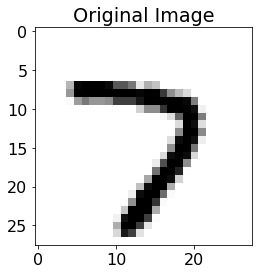

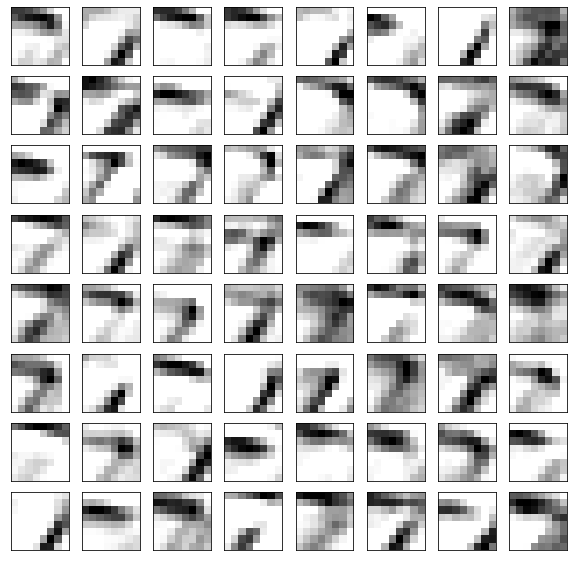

In [ ]:
# Grab a single test image to examine
example_image = X_test[17] # <-- Try grabbing other test images, too!

# Run the visualization funtion to examine some of the convolutions
output_layer_to_visualize = 1
visualize_convolutions(model, output_layer_to_visualize, example_image)

Examine the output convolved images for each of the primary layers of your CNN. Consider what these output convolved images represent.

**Question 2:** Based on your answer to Question 1, above, how would you respond to someone who asked you "What information is your CNN extracting from the input images to classify them correctly?"

The CNN is extracting information about the edges and corners of the numbers to classify them correctly.

# Conclusion

In this notebook, we built a 2D CNN to perform image classification on the MNIST dataset. Although we were able to achieve fairly good performance on this dataset, we have potentially sacrificed some of the interpretability that comes with more conventional approaches to image classification.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ccdb29b9-b801-4172-baf4-71cab3f2ea28' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>